# DATA2001 Report Data Analysis Workflow

**SID: 490428890, 510067773**

## Importing Data

We first imported the python packages needed to process our data files. We then imported the files into python to be cleaned.

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiLineString
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

businesses = pd.read_csv('Businesses.csv')
income = pd.read_csv('Income.csv')
pp = pd.read_csv('PollingPlaces2019.csv')
pop = pd.read_csv('population.csv')
stops = pd.read_csv('Stops.txt')
sa2 = gpd.read_file('SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
primary = gpd.read_file('catchments/catchments_primary.shp')
cf = gpd.read_file('catchments/catchments_future.shp')
secondary = gpd.read_file('catchments/catchments_secondary.shp')

## Data Processing and Cleaning

We looked through the datasets and notices that the income dataset have values with `np` values.

In [2]:
income[income.eq('np').any(1)]

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
74,103031075,Wollangambe - Wollemi,np,np,np,np
131,107011133,Port Kembla Industrial,np,np,np,np
352,118011342,Centennial Park,np,np,np,np
458,123021439,Holsworthy Military Area,np,np,np,np
475,124021456,Blue Mountains - South,np,np,np,np
493,125011475,Rookwood Cemetery,np,np,np,np


These rows were removed with the following code:

In [3]:
income = income[income['earners'] != 'np']

The `.point_from_xy` function was used to convert latitude and longitude values from the stops dataframe into proper geographical points. A new column 'geom' will be created to store the coordinate values. The longitude (`stop_lon`) and latitude (`stop_lon`) columns will also be dropped from the stops dataframe.

In [4]:
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)
stops = stops.drop(columns = ['stop_lon', 'stop_lat'])
stops

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0,NaN,POINT (151.20666 -33.88221)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0,NaN,POINT (151.20699 -33.88204)
2,200060,NaN,Central Station,1.0,NaN,0,NaN,POINT (151.20629 -33.88408)
3,201510,NaN,Redfern Station,1.0,NaN,0,NaN,POINT (151.19887 -33.89169)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,NaN,POINT (151.19888 -33.89333)
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",NaN,21271,1,B,POINT (151.07880 -33.82202)
114714,2137185,2137185.0,"Cabarita Wharf, Side A",NaN,21371,1,1A,POINT (151.11693 -33.84067)
114715,2137186,2137186.0,"Cabarita Wharf, Side B",NaN,21371,1,1B,POINT (151.11690 -33.84077)
114716,21501,21501.0,Parramatta Wharf,NaN,2150112,1,NaN,POINT (151.01058 -33.81390)


We then converted the point coordinates in the `geom` column into **Well Known Text (WKT)** format. This requires the `geoalchemy2` library to convert `shapely` types in GeoPandas to the WKT format in PostGIS. 

We specified the SRID to 7844 to represent GDA2020, the Geocentric Datum of Australia 2020.

In [5]:
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=7844))
stops

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0,NaN,POINT (151.20666465471 -33.8822064874687)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0,NaN,POINT (151.20699145565 -33.8820421431408)
2,200060,NaN,Central Station,1.0,NaN,0,NaN,POINT (151.206292455081 -33.8840842535493)
3,201510,NaN,Redfern Station,1.0,NaN,0,NaN,POINT (151.198866071817 -33.8916900512711)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,NaN,POINT (151.198881722942 -33.8933293130144)
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",NaN,21271,1,B,POINT (151.07879697831 -33.8220164586429)
114714,2137185,2137185.0,"Cabarita Wharf, Side A",NaN,21371,1,1A,POINT (151.116926480557 -33.8406690716775)
114715,2137186,2137186.0,"Cabarita Wharf, Side B",NaN,21371,1,1B,POINT (151.116898892402 -33.8407691073139)
114716,21501,21501.0,Parramatta Wharf,NaN,2150112,1,NaN,POINT (151.010576673346 -33.8139042429414)


The same was done for the `PollingPlaces2019` dataset `pp`

In [6]:
pp['geom'] = gpd.points_from_xy(pp.longitude, pp.latitude)
pp = pp.drop(columns = ['latitude', 'longitude', 'the_geom'])

In [7]:
pp['geom'] = pp['geom'].apply(lambda x: WKTElement(x.wkt, srid=7844))
pp

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,POINT EMPTY
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,POINT EMPTY
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,POINT EMPTY
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,POINT EMPTY
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,NaN,NaN,BARRACK HEIGHTS,NSW,2528.0,POINT (150.858 -34.5642)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,NaN,NaN,NaN,WARILLA,NSW,2528.0,POINT (150.8597546 -34.5508228)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,NaN,NaN,WELBY,NSW,2575.0,POINT (150.424 -34.4409)
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,NaN,NaN,WINDANG,NSW,2528.0,POINT (150.866 -34.5316)


We also converted the `shapely` types in the `sa2` dataframe into WKT format, with the help of an additional function which converts the `Polygon` geom type into `MultiPolygon` geom type.

Some data cleaning was also performed where rows containing None values in the `geometry` column in sa2 were dropped.

    - sa2 dataset was filtered to only include data from Greater Sydney

After conversion to WKT format, the old `geometry` column was dropped.

In [8]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

sa2 = sa2.dropna(subset = ['geometry'])

sa2 = sa2[sa2['GCC_NAME21'] == 'Greater Sydney']
sa2og = sa2.copy()  # creating a copy of the original for later
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=7844))  # applying the function
sa2 = sa2.drop(columns="geometry")  # deleting the old cop
sa2

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geom
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.07362997413264 -34.0563789...
638,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.05006441218998 -34.0215774...
639,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((150.99568346574816 -34.0536082...
640,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.03954821100714 -34.0417452...


For the catchment dataframes, we specified SRID to 4283 to represent GDA94, Geocentric Datrum of Australia 1994.

In [9]:
primary['geom'] = primary['geometry'].apply(lambda x: create_wkt_element(geom = x, srid = 4283))
primary = primary.drop(columns = 'geometry')
cf['geom'] = cf['geometry'].apply(lambda x: create_wkt_element(geom = x, srid = 4283))
cf = cf.drop(columns = 'geometry')
secondary['geom'] = secondary['geometry'].apply(lambda x: create_wkt_element(geom = x, srid = 4283))
secondary = secondary.drop(columns = 'geometry')
primary

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,MULTIPOLYGON (((151.1537883781186 -33.75586174...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,4383,PRIMARY,E A Southee PS,20200315,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,MULTIPOLYGON (((147.9462089946497 -34.55863148...
1658,3275,PRIMARY,Tumbarumba PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,MULTIPOLYGON (((148.12885348977485 -35.6008184...
1659,2239,PRIMARY,Jindera PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,MULTIPOLYGON (((146.86147943204122 -35.8751106...
1660,3594,PRIMARY,Louth PS,20200604,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,MULTIPOLYGON (((145.18402754685187 -29.6580498...


## Connecting to SQL

The following functions below will be used to connect to the SQL server and to query from the SQL server database through python:

In [10]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema = "public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host = db_conn_dict['host']
        db_user = db_conn_dict['user']
        db_pw = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo = False)
            conn = db.connect()
            print('Connected Sucessfully.')
        except Exception as e:
            print('Unable to connect to the database')
            print(e)
            db, conn = None, None
        return db, conn

def query(conn, sqlcmd, args = None, df = True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params = args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print('Error encountered: ', e, sep = '\n')
    return result

In [11]:
db, conn = pgconnect(credentials)

Connected Sucessfully.


In [12]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


We created the data schema for our SQL server, `sa2_code` was set as our primary key for most of our tables:

In [13]:
conn.execute("""CREATE EXTENSION IF NOT EXISTS "uuid-ossp";""")

conn.execute("""
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses(
    id uuid PRIMARY KEY DEFAULT uuid_generate_v4(),
    industry_code VARCHAR(1),
    industry_name VARCHAR(100),
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    "0_to_50k_businesses" INTEGER,
    "50k_to_200k_businesses" INTEGER,
    "200k_to_2m_businesses" INTEGER,
    "2m_to_5m_businesses" INTEGER,
    "5m_to_10m_businesses" INTEGER,
    "10m_or_more_businesses" INTEGER,
    total_businesses INTEGER
);
""")

conn.execute("""
DROP TABLE IF EXISTS income;
CREATE TABLE income(
    sa2_code VARCHAR(100) PRIMARY KEY,
    sa2_name VARCHAR(100),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER
);
""")

conn.execute("""
DROP TABLE IF EXISTS polling_places;
CREATE TABLE polling_places(
    "FID" VARCHAR(200),
    state VARCHAR(10),
    division_id INTEGER,
    division_name VARCHAR(100),
    polling_place_id INTEGER PRIMARY KEY,
    polling_place_type_id INTEGER,
    polling_place_name VARCHAR(100),
    premises_name VARCHAR(300),
    premises_address_1 VARCHAR(300),
    premises_address_2 VARCHAR(300),
    premises_address_3 VARCHAR(300),
    premises_suburb VARCHAR(100),
    premises_state_abbreviation VARCHAR(100),
    premises_post_code NUMERIC,
    geom GEOMETRY(POINT, 7844)
);
""")

conn.execute("""
DROP TABLE IF EXISTS population;
CREATE TABLE population(
    sa2_code VARCHAR(100) PRIMARY KEY,
    sa2_name VARCHAR(100),
    "0-4_people" INTEGER,
    "5-9_people" INTEGER,
    "10-14_people" INTEGER,
    "15-19_people" INTEGER,
    "20-24_people" INTEGER,
    "25-29_people" INTEGER,
    "30-34_people" INTEGER,
    "35-39_people" INTEGER,
    "40-44_people" INTEGER,
    "45-49_people" INTEGER,
    "50-54_people" INTEGER,
    "55-59_people" INTEGER,
    "60-64_people" INTEGER,
    "65-69_people" INTEGER,
    "70-74_people" INTEGER,
    "75-79_people" INTEGER,
    "80-84_people" INTEGER,
    "85-and-over_people" INTEGER,
    total_people INTEGER   
);
""")

conn.execute("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops(
    stop_id VARCHAR(100) PRIMARY KEY,
    stop_code NUMERIC,
    stop_name VARCHAR(100),
    location_type NUMERIC,
    parent_station VARCHAR(100),
    wheelchair_boarding INTEGER,
    platform_code VARCHAR(10),
    geom GEOMETRY(POINT,7844)
);
""")

conn.execute("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2(
    "SA2_CODE21" VARCHAR(100) PRIMARY KEY,
    "SA2_NAME21" VARCHAR(100),
    "CHG_FLAG21" INTEGER,
    "CHG_LBL21" VARCHAR(100),
    "SA3_CODE21" INTEGER,
    "SA3_NAME21" VARCHAR(100),
    "SA4_CODE21" INTEGER,
    "SA4_NAME21" VARCHAR(100),
    "GCC_CODE21" VARCHAR(100),
    "GCC_NAME21" VARCHAR(100),
    "STE_CODE21" INTEGER,
    "STE_NAME21" VARCHAR(100),
    "AUS_CODE21" VARCHAR(10),
    "AUS_NAME21" VARCHAR(100),
    "AREASQKM21" NUMERIC(18,4),
    "LOCI_URI21" VARCHAR(300),
    geom GEOMETRY(MULTIPOLYGON,7844)
);
""")

conn.execute("""
DROP TABLE IF EXISTS prim;
CREATE TABLE prim(
    "USE_ID" INTEGER PRIMARY KEY,
    "CATCH_TYPE" VARCHAR(100),
    "USE_DESC" VARCHAR(100),
    "ADD_DATE" DATE,
    "KINDERGART" BOOLEAN,
    "YEAR1" BOOLEAN,
    "YEAR2" BOOLEAN,
    "YEAR3" BOOLEAN,
    "YEAR4" BOOLEAN,
    "YEAR5" BOOLEAN,
    "YEAR6" BOOLEAN,
    "YEAR7" BOOLEAN,
    "YEAR8" BOOLEAN,
    "YEAR9" BOOLEAN,
    "YEAR10" BOOLEAN,
    "YEAR11" BOOLEAN,
    "YEAR12" BOOLEAN,
    "PRIORITY" VARCHAR(10),
    geom GEOMETRY(MULTIPOLYGON,4283)
);
""")

conn.execute("""
DROP TABLE IF EXISTS secondary;
CREATE TABLE secondary(
    "USE_ID" INTEGER PRIMARY KEY,
    "CATCH_TYPE" VARCHAR(100),
    "USE_DESC" VARCHAR(100),
    "ADD_DATE" DATE,
    "KINDERGART" BOOLEAN,
    "YEAR1" BOOLEAN,
    "YEAR2" BOOLEAN,
    "YEAR3" BOOLEAN,
    "YEAR4" BOOLEAN,
    "YEAR5" BOOLEAN,
    "YEAR6" BOOLEAN,
    "YEAR7" BOOLEAN,
    "YEAR8" BOOLEAN,
    "YEAR9" BOOLEAN,
    "YEAR10" BOOLEAN,
    "YEAR11" BOOLEAN,
    "YEAR12" BOOLEAN,
    "PRIORITY" VARCHAR(10),
    geom GEOMETRY(MULTIPOLYGON,4283)
);
""")

The datasets were then imported into the SQL server:

In [14]:
businesses.to_sql('businesses', conn, if_exists='append', index=False)
income.to_sql('income', conn, if_exists = 'append', index=False)
pp.to_sql('polling_places', conn, if_exists = 'append', index=False, dtype={'geom': Geometry('POINT',srid=7844)})
pop.to_sql('population', conn, if_exists = 'append', index=False)
stops.to_sql('stops', conn, if_exists = 'append', index=False, dtype={'geom': Geometry('POINT', srid = 7844)})
sa2.to_sql('sa2', conn, if_exists = 'append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid = 7844)})
primary.to_sql('prim', conn, if_exists = 'append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid = 4283)})
secondary.to_sql('secondary', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid = 4283)})

436

We also created additional spatial indexes on `geom` columns for faster spatial querying:

In [15]:
conn.execute("""
CREATE INDEX sa2_gid 
    ON sa2
    USING gist(geom);
CREATE INDEX pp_gid
    ON polling_places
    USING gist(geom);
CREATE INDEX stops_gid
    ON stops
    USING gist(geom);
CREATE INDEX prim_gid
    ON prim
    USING gist(ST_Transform(geom, 7844));
CREATE INDEX secondary_gid
    ON secondary
    USING gist(ST_Transform(geom, 7844));
""")

## Obtaining data

We queried our SQL server to obtain the dataframe needed to otain z_scores for health businesses per 1000 people in each SA2 region.

Python code was then used to calculate the z score for each SA2 region.

In [16]:
health = """
SELECT s."SA2_CODE21", s."SA2_NAME21", total_businesses, total_people
    FROM sa2 s
    LEFT JOIN businesses b ON s."SA2_CODE21" = b.sa2_code
    LEFT JOIN population p ON s."SA2_CODE21"= p.sa2_code 
    WHERE industry_name = 'Health Care and Social Assistance' AND total_people >= 100
"""

health_bus = query(conn, health) 
health_bus['health_bus_per_1000'] = health_bus['total_businesses']/(health_bus['total_people']/1000) # calculating health businesses per 1000 people for each SA2 region
health_bus['z_score'] = (health_bus['health_bus_per_1000']-health_bus['health_bus_per_1000'].mean())/health_bus['health_bus_per_1000'].std() # calculating z scores
z_health = health_bus[['SA2_CODE21', 'SA2_NAME21', 'z_score']]
z_health

,SA2_CODE21,SA2_NAME21,z_score
0,102011028,Avoca Beach - Copacabana,0.214313
1,102011029,Box Head - MacMasters Beach,-0.381019
2,102011030,Calga - Kulnura,0.119702
3,102011031,Erina - Green Point,0.691238
4,102011032,Gosford - Springfield,0.750302
...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,-0.459882
356,128021538,Sutherland - Kirrawee,-0.056965
357,128021607,Engadine,-0.448008
358,128021608,Loftus - Yarrawarrah,-0.624620


The same was done for retail businesses per 1000 people in each SA2 region

In [17]:
retail = """
SELECT s."SA2_CODE21", s."SA2_NAME21", industry_name, total_businesses, total_people
    FROM sa2 s
    LEFT JOIN businesses b on s."SA2_CODE21"=b.sa2_code
    LEFT JOIN population p on s."SA2_CODE21"=p.sa2_code
    WHERE industry_name = 'Retail Trade' AND total_people >= 100
"""

retail_bus = query(conn, retail)
retail_bus['retail_bus_per_1000'] = retail_bus['total_businesses']/(retail_bus['total_people']/1000) # calculating retail businesses per 1000 people for each SA2 region
retail_bus['z_score'] = (retail_bus['retail_bus_per_1000']-retail_bus['retail_bus_per_1000'].mean())/retail_bus['retail_bus_per_1000'].std() # calculating z score
z_retail = retail_bus[['SA2_CODE21','SA2_NAME21', 'z_score']]
z_retail

,SA2_CODE21,SA2_NAME21,z_score
0,102011028,Avoca Beach - Copacabana,-0.148509
1,102011029,Box Head - MacMasters Beach,-0.300496
2,102011030,Calga - Kulnura,0.482556
3,102011031,Erina - Green Point,0.300755
4,102011032,Gosford - Springfield,0.108608
...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,-0.325128
356,128021538,Sutherland - Kirrawee,-0.218631
357,128021607,Engadine,-0.364483
358,128021608,Loftus - Yarrawarrah,-0.361273


Obtaining the dataframes for school catchment areas were more complex as we could not join on `sa2_code`.

To solve this we joined our dataframes using spatial joins which were sped up with the use of spatial indexes created earlier.

Python code was used to merge our dataframes for primary and secondary school catchment areas as well as to calculate the z_score for school catchment areas per 1000 young people for each SA2 region.

In [18]:
school = """
SELECT s."SA2_CODE21", s."SA2_NAME21", COUNT(p."USE_ID") AS primary_schools
    FROM sa2 s
    LEFT JOIN prim p ON ST_Intersects(ST_Transform(p.geom, 7844), s.geom)
    LEFT JOIN population pop ON pop.sa2_code=s."SA2_CODE21"
    WHERE total_people >= 100
    GROUP BY s."SA2_CODE21", s."SA2_NAME21"
    ORDER BY s."SA2_NAME21";
"""

primary_schools = query(conn, school)

sec = """
SELECT s."SA2_CODE21", s."SA2_NAME21", COUNT(sec."USE_ID") AS "secondary_schools", p."0-4_people", p."5-9_people", p."10-14_people", p."15-19_people", p."0-4_people" + p."5-9_people" + p."10-14_people" + p."15-19_people" AS "young_people"
    FROM sa2 s
    LEFT JOIN secondary sec ON ST_Intersects(ST_Transform(sec.geom, 7844), s.geom)
    LEFT JOIN population p ON p.sa2_code=s."SA2_CODE21"
    WHERE total_people >= 100
    GROUP BY s."SA2_CODE21", s."SA2_NAME21", p."0-4_people", p."5-9_people", p."10-14_people", p."15-19_people"
    ORDER BY s."SA2_NAME21";
"""

secondary_schools = query(conn, sec)

schools = pd.merge(primary_schools, secondary_schools, how = 'outer', on=['SA2_CODE21', 'SA2_NAME21'])
schools['total_schools'] = schools['primary_schools'] + schools['secondary_schools']
schools['schools_per_1000_young_people'] = schools['total_schools']/(schools['young_people']/1000) # calculating school catchment areas per 1000 young people for each SA2 region
schools['z_score'] = (schools['schools_per_1000_young_people']-schools['schools_per_1000_young_people'].mean())/schools['schools_per_1000_young_people'].std() # calculating z scores
z_schools = schools[['SA2_CODE21', 'SA2_NAME21', 'z_score']]
z_schools

,SA2_CODE21,SA2_NAME21,z_score
0,116021562,Acacia Gardens,0.075784
1,120021674,Annandale (NSW),-0.022360
2,119041668,Arncliffe - Bardwell Valley,-0.040382
3,121011682,Artarmon,-0.051638
4,127011504,Ashcroft - Busby - Miller,-0.247381
...,...,...,...
355,102011043,Wyoming,-0.061180
356,102021057,Wyong,-0.125897
357,119011361,Yagoona - Birrong,-0.313618
358,124041468,Yarramundi - Londonderry,1.008813


The same was done for federal polling locations and bus stops of each SA2 region.

In [19]:
sql = """
SELECT sa2."SA2_CODE21", count(pp.geom)
FROM sa2 left join polling_places pp on ST_Contains(sa2.geom, pp.geom) left join population p on (p.sa2_code = sa2."SA2_CODE21")
WHERE p.total_people >= 100
GROUP BY sa2."SA2_CODE21";
"""

z_pp = query(conn, sql)
z_pp['z_score'] = (z_pp['count']-z_pp['count'].mean())/z_pp['count'].std() # calculating z score
z_pp

,SA2_CODE21,count,z_score
0,102011028,2,-0.536177
1,102011029,2,-0.536177
2,102011030,7,0.674763
3,102011031,6,0.432575
4,102011032,7,0.674763
...,...,...,...
355,128021536,7,0.674763
356,128021538,6,0.432575
357,128021607,7,0.674763
358,128021608,2,-0.536177


In [20]:
sql = """
SELECT sa2."SA2_CODE21", count(*)
FROM sa2 join stops on ST_Contains(sa2.geom, stops.geom) join population p on (p.sa2_code = sa2."SA2_CODE21")
WHERE p.total_people >= 100
GROUP BY sa2."SA2_CODE21";
"""

z_stops = query(conn, sql)
z_stops['z_score'] = (z_stops['count'] - z_stops['count'].mean())/z_stops['count'].std()

z_stops

,SA2_CODE21,count,z_score
0,102011028,127,-0.311193
1,102011029,215,0.724482
2,102011030,172,0.218414
3,102011031,285,1.548314
4,102011032,355,2.372146
...,...,...,...
355,128021536,254,1.183474
356,128021538,195,0.489101
357,128021607,221,0.795096
358,128021608,144,-0.111119


## Sigmoid Function

We created a sigmoid function to calculate how well resourced a region is:

In [21]:
import math

def sigmoid(x):
    return 1/(1+math.exp(-x))

We merged the z scores of each region into one dataframe and ran the function on all the z scores of each SA2 region:

$$ "well\:resourced" score = S(z_{retail} + z_{health} + z_{schools} + z_{polls} + z_{stops})$$

In [22]:
z_all = pd.merge(z_health, z_retail, on = ['SA2_CODE21', 'SA2_NAME21'])
z_all = z_all.merge(z_schools, on = ['SA2_CODE21', 'SA2_NAME21'])
z_all = z_all.rename(columns = {'z_score_x': 'z_health', 'z_score_y': 'z_retail', 'z_score': 'z_schools'})
z_all = z_all.merge(z_pp, on = ['SA2_CODE21'])
z_all = z_all.merge(z_stops, on = ['SA2_CODE21'])
z_all = z_all.rename(columns = {'z_score_x': 'z_pp', 'z_score_y': 'z_stops'})
z_all = z_all.drop(columns = ['count_x', 'count_y'])
z_all['sum'] = z_all['z_health'] + z_all['z_retail'] + z_all['z_schools'] + z_all['z_pp'] + z_all['z_stops']
z_all['score'] = z_all['sum'].apply(lambda x: sigmoid(x))
z_all = z_all.sort_values(by=['score'], ascending = False)
z_all

,SA2_CODE21,SA2_NAME21,z_health,z_retail,z_schools,z_pp,z_stops,sum,score
93,117031644,Sydney (North) - Millers Point,14.365900,15.911753,1.371389,14.479481,0.300797,46.429320,1.000000
73,117011320,Banksmeadow,-0.265572,6.658318,16.545614,-1.020553,-1.594017,20.323789,1.000000
42,115021297,Dural - Kenthurst - Wisemans Ferry,-0.154968,0.273331,0.255773,1.159139,6.397155,7.930430,0.999640
94,117031645,Sydney (South) - Haymarket,0.884180,1.654218,0.273815,5.518524,-0.899644,7.431093,0.999408
184,121011684,Chatswood - East,2.192795,1.015502,-0.241537,2.854455,-0.111119,5.710095,0.996699
...,...,...,...,...,...,...,...,...,...
340,127031730,Edmondson Park,-0.283240,-0.238809,-0.288321,-0.778365,-1.252715,-2.841451,0.055125
5,102011033,Kariong,-0.577530,-0.452862,-0.364464,-0.536177,-1.040873,-2.971906,0.048711
64,116021631,Schofields (West) - Colebee,-0.552279,-0.315911,-0.042405,-1.020553,-1.064411,-2.995559,0.047627
24,102021052,Summerland Point - Gwandalan,-0.615188,-0.501039,-0.482776,-0.536177,-1.111487,-3.246667,0.037447


## Plotting Results

We plotted our scores into a kernel density distribution and a boxplot:

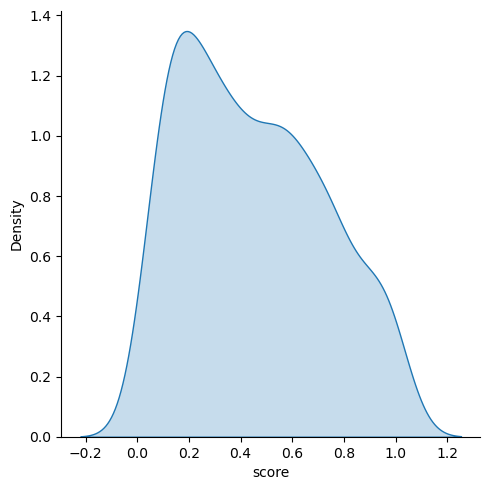

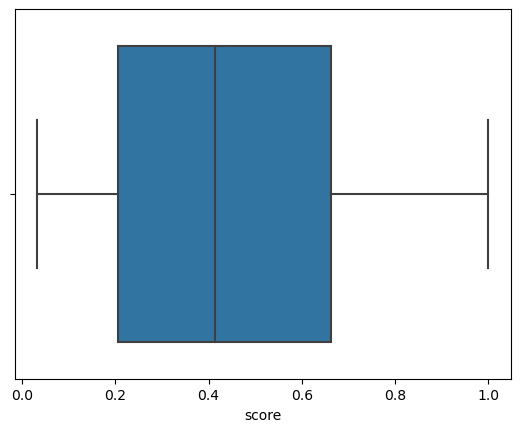

In [23]:
import plotly.figure_factory as ff
import seaborn as sns
import kaleido 

fig1 = sns.displot(z_all, x="score", kind = 'kde', fill = True)
plt.show()
fig1.savefig('fig1.png')

fig2 = sns.boxplot(x=z_all['score'])
plt.show()
fig2.get_figure().savefig('fig2.png')

To plot our results, we first merged our score dataframe with our original sa2 dataset:

In [24]:
data = sa2og.merge(z_all, on = ['SA2_CODE21', 'SA2_NAME21'])

**Regions Heatmap**

We then plotted this dataset and used a color gradient to visually score each SA2 region based on their "well resourced" score that we calculated:

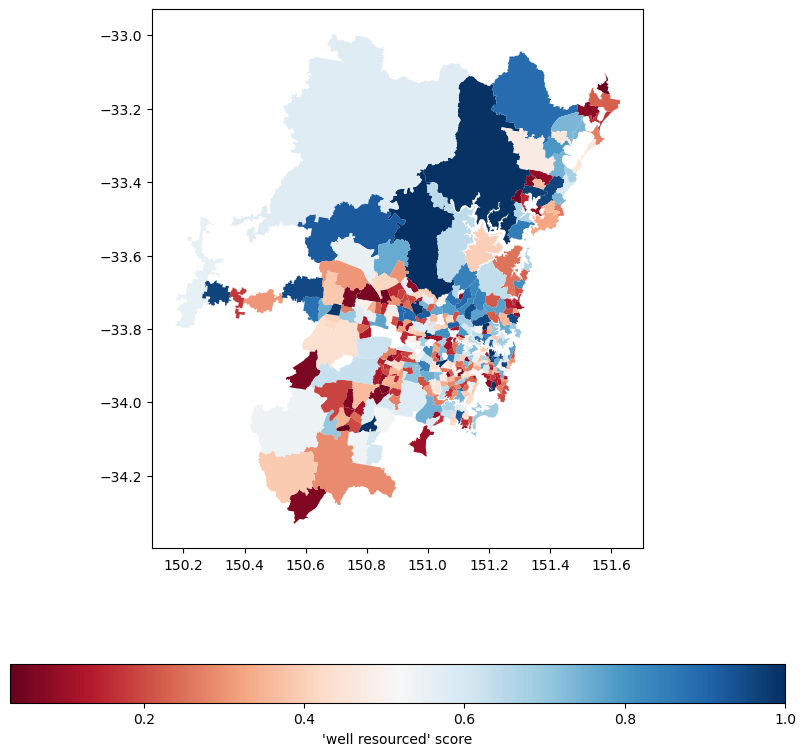

In [25]:
fig3 = data.plot(figsize = (10, 10), column = "score", cmap = 'RdBu', legend = True, legend_kwds={"label": "'well resourced' score", "orientation": "horizontal"})
plt.show()
fig3.get_figure().savefig('fig3.png')

**Scatter Plot**

In [26]:
score = z_all[['SA2_CODE21', 'score']]
score = score.astype({'SA2_CODE21': 'int64'})
correlation = income.astype({'median_income': 'int64'})
correlation = correlation.merge(score, left_on = ['sa2_code'], right_on = ['SA2_CODE21'])

In [27]:
import plotly.express as px
fig4 = px.scatter(correlation, y="median_income", x="score", color = "score", color_continuous_scale=px.colors.sequential.RdBu, trendline = 'ols')
fig4.update(layout = {'plot_bgcolor': 'lightgray'})
fig4.show()
fig4.write_image('fig4.png')
fig4.write_html('fig4.html')

## Adding more variables

We added a bike lanes and electric vehicle parking to our scoring system

**Importing Data**

In [28]:
ev = pd.read_csv('Electric-Vehicle-Charging-Stations-NSW-20211207.csv')
bikes = gpd.read_file('Cycle_network.geojson')

**Data Cleaning**

In [29]:
def create_wkt_element_line(geom, srid):
    if geom.geom_type == 'LineString':
        geom = MultiLineString([geom])
    return WKTElement(geom.wkt, srid)

bikes['geom'] = bikes['geometry'].apply(lambda x: create_wkt_element_line(geom=x,srid=7844))
bikes = bikes.drop(columns="geometry")

ev['geom'] = gpd.points_from_xy(ev.Longitude, ev.Latitude)
ev = ev.drop(columns = ['Latitude', 'Longitude'])
ev = ev.drop(columns = ['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'])
ev['geom'] = ev['geom'].apply(lambda x: WKTElement(x.wkt, srid=7844))

**Creating SQL Server Database Schema**

In [30]:
conn.execute("""
DROP TABLE IF EXISTS ev;
CREATE TABLE ev(
    id uuid PRIMARY KEY DEFAULT uuid_generate_v4(),
    "Organisation_Name" VARCHAR(100),
    "Service_Station_Location" VARCHAR(100),
    geom GEOMETRY(POINT, 7844)
);
""")

conn.execute("""
DROP TABLE IF EXISTS bikes;
CREATE TABLE bikes(
    "OBJECTID" INTEGER PRIMARY KEY,
    "RouteType" VARCHAR(1000),
    "Source" VARCHAR(1000),
    "Shape__Length" FLOAT,
    geom GEOMETRY(MULTILINESTRING,7844)
);
""")

**Creating Spatial Indexes**

In [31]:
conn.execute("""
CREATE INDEX ev_gid 
    ON ev
    USING gist(geom);
CREATE INDEX bikes_gid
    ON bikes
    USING gist(geom);
""")

**Importing to SQL Server**

In [32]:
ev.to_sql('ev', conn, if_exists = 'append', index=False, dtype={'geom': Geometry('POINT', srid = 7844)})
bikes.to_sql('bikes', conn, if_exists = 'append', index=False, dtype={'geom': Geometry('MultiLineString', srid = 7844)})

594

**Querying and Computing Z scores**

In [33]:
sql = """
SELECT sa2."SA2_CODE21", sa2."SA2_NAME21", SUM(ST_Length(ST_Intersection(bikes.geom,sa2.geom)))
FROM sa2 join bikes on ST_Intersects(bikes.geom, sa2.geom) join population p on (p.sa2_code = sa2."SA2_CODE21")
WHERE p.total_people >= 100
GROUP BY sa2."SA2_CODE21";
"""

bikes_z = query(conn, sql)
bikes_z['z'] = (bikes_z['sum']-bikes_z['sum'].mean())/bikes_z['sum'].std()
z_bikes = bikes_z[['SA2_CODE21', 'z']]

bikes_z

,SA2_CODE21,SA2_NAME21,sum,z
0,117011323,Pagewood - Hillsdale - Daceyville,0.000012,-1.080485
1,117011634,Eastlakes,0.029816,-0.753464
2,117011635,Mascot,0.032886,-0.719771
3,117021327,Petersham - Stanmore,0.013154,-0.936283
4,117031329,Darlinghurst,0.129837,0.344006
5,117031330,Erskineville - Alexandria,0.303391,2.248297
6,117031331,Glebe - Forest Lodge,0.220927,1.343469
7,117031333,Potts Point - Woolloomooloo,0.093836,-0.051015
8,117031336,Surry Hills,0.167822,0.760782
9,117031638,Camperdown - Darlington,0.124615,0.286709


In [34]:
sql = """
SELECT sa2."SA2_CODE21", sa2."SA2_NAME21", count(*)
FROM sa2 join ev on ST_Contains(sa2.geom, ev.geom) join population p on (p.sa2_code = sa2."SA2_CODE21")
WHERE p.total_people >= 100
GROUP BY sa2."SA2_CODE21";
"""

ev_z = query(conn, sql)
ev_z['z'] = (ev_z['count']-ev_z['count'].mean())/ev_z['count'].std()
z_ev = ev_z[['SA2_CODE21', 'z']]

z_ev

,SA2_CODE21,z
0,102021055,-0.428174
1,115011555,-0.428174
2,116021631,-0.428174
3,117031644,2.140872
4,117031645,-0.428174
5,118021564,-0.428174
6,120031396,-0.428174
7,121011684,-0.428174
8,122031432,-0.428174
9,123031447,-0.428174


**Computing "Well-Resourced" Score**

In [35]:
z_all2 = pd.merge(z_health, z_retail, on = ['SA2_CODE21', 'SA2_NAME21'])
z_all2 = z_all2.merge(z_schools, on = ['SA2_CODE21', 'SA2_NAME21'])
z_all2 = z_all2.rename(columns = {'z_score_x': 'z_health', 'z_score_y': 'z_retail', 'z_score': 'z_schools'})
z_all2 = z_all2.merge(z_pp, on = ['SA2_CODE21'])
z_all2 = z_all2.merge(z_stops, on = ['SA2_CODE21'])
z_all2 = z_all2.rename(columns = {'z_score_x': 'z_pp', 'z_score_y': 'z_stops'})
z_all2 = z_all2.drop(columns = ['count_x', 'count_y'])
z_all2 = z_all2.merge(z_bikes, on = ['SA2_CODE21'], how = 'left')
z_all2 = z_all2.merge(z_ev, on = ['SA2_CODE21'], how = 'left')
z_all2 = z_all2.rename(columns = {'z_x': 'z_bike_lanes', 'z_y': 'z_ev_stations'})
z_all2 = z_all2.fillna(0)
z_all2['sum'] = z_all2['z_health'] + z_all2['z_retail'] + z_all2['z_schools'] + z_all2['z_pp'] + z_all2['z_stops'] + z_all2['z_bike_lanes'] + z_all2['z_ev_stations']
z_all2['score'] = z_all2['sum'].apply(lambda x: sigmoid(x))
z_all2 = z_all2.sort_values(by=['score'], ascending = False)
z_all2

,SA2_CODE21,SA2_NAME21,z_health,z_retail,z_schools,z_pp,z_stops,z_bike_lanes,z_ev_stations,sum,score
93,117031644,Sydney (North) - Millers Point,14.365900,15.911753,1.371389,14.479481,0.300797,2.689333,2.140872,51.259525,1.000000
73,117011320,Banksmeadow,-0.265572,6.658318,16.545614,-1.020553,-1.594017,0.000000,0.000000,20.323789,1.000000
42,115021297,Dural - Kenthurst - Wisemans Ferry,-0.154968,0.273331,0.255773,1.159139,6.397155,0.000000,0.000000,7.930430,0.999640
94,117031645,Sydney (South) - Haymarket,0.884180,1.654218,0.273815,5.518524,-0.899644,0.587362,-0.428174,7.590280,0.999495
119,119011355,Chullora,0.749626,4.247405,2.724840,-1.020553,-1.288022,0.000000,0.000000,5.413295,0.995563
...,...,...,...,...,...,...,...,...,...,...,...
5,102011033,Kariong,-0.577530,-0.452862,-0.364464,-0.536177,-1.040873,0.000000,0.000000,-2.971906,0.048711
75,117011323,Pagewood - Hillsdale - Daceyville,-0.453817,-0.202293,-0.182227,-0.293989,-0.817261,-1.080485,0.000000,-3.030072,0.046086
24,102021052,Summerland Point - Gwandalan,-0.615188,-0.501039,-0.482776,-0.536177,-1.111487,0.000000,0.000000,-3.246667,0.037447
230,123011702,Spring Farm,-0.735872,-0.424842,-0.190141,-0.778365,-1.252715,0.000000,0.000000,-3.381936,0.032865


## Plotting Results (2)

In [36]:
data2 = sa2og.merge(z_all2, on = ['SA2_CODE21', 'SA2_NAME21'])

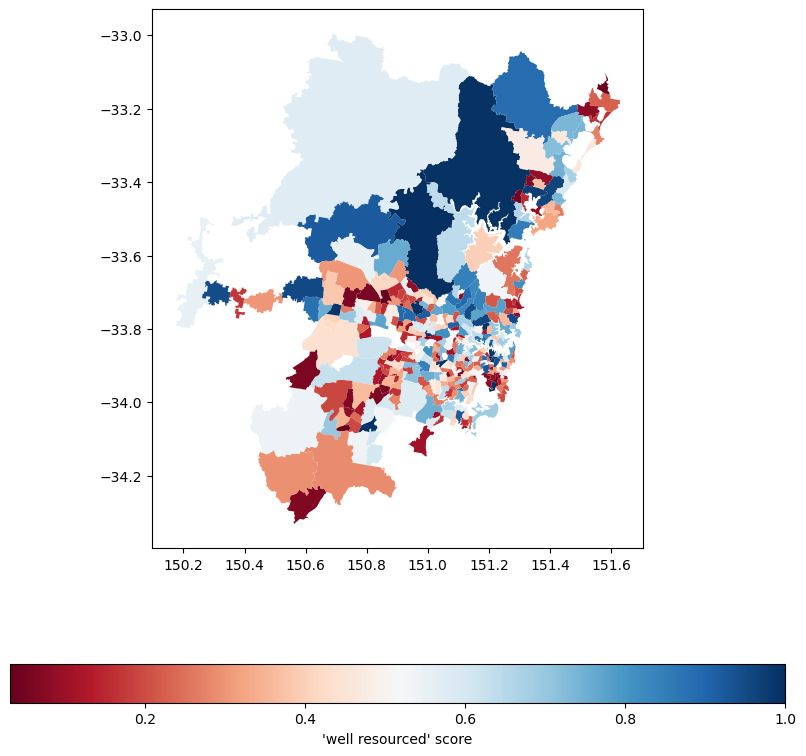

In [37]:
fig5 = data2.plot(figsize = (10, 10), column = "score", cmap = 'RdBu', legend = True, legend_kwds={"label": "'well resourced' score", "orientation": "horizontal"})
fig5.get_figure().savefig('fig5.png')
plt.show()

In [38]:
score2 = z_all2[['SA2_CODE21', 'score']]
score2 = score2.astype({'SA2_CODE21': 'int64'})
correlation2 = income.astype({'median_income': 'int64'})
correlation2 = correlation2.merge(score2, left_on = ['sa2_code'], right_on = ['SA2_CODE21'])
import plotly.express as px
fig6 = px.scatter(correlation2, y="median_income", x="score", color = "score", color_continuous_scale=px.colors.sequential.RdBu, trendline = 'ols')
fig6.update(layout = {'plot_bgcolor': 'lightgray'})
fig6.show()
fig6.write_image('fig6.png')
fig6.write_html('fig6.html')

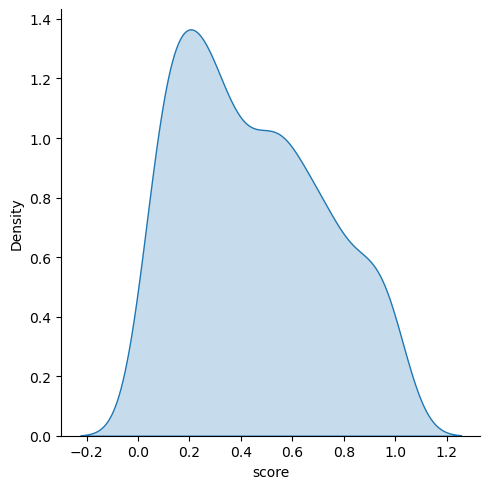

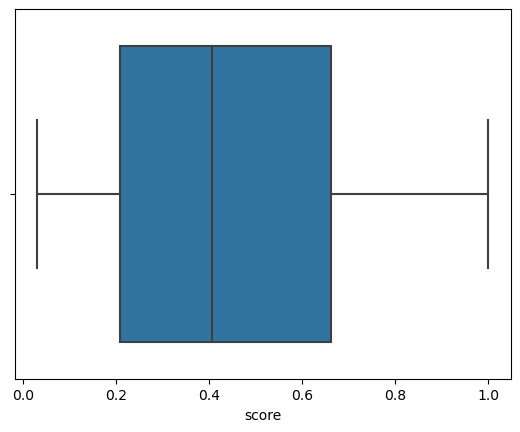

In [39]:
fig7 = sns.displot(z_all2, x="score", kind = 'kde', fill = True)
plt.show()
fig7.savefig('fig7.png')

fig8 = sns.boxplot(x=z_all2['score'])
plt.show()
fig8.get_figure().savefig('fig8.png')

In [40]:
conn.close()
db.dispose()